#### Value at Risk (VaR) Analysis using the Parametric Method for a portfolio of stocks using Python.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

# Set the time range to a certain number of years and create a list of tickers we want to analyze. 
# In this example, we’ll analyze the past 15 years of stock data.

years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [2]:
# Download the daily adjusted close prices for each ticker in our list using the yfinance library.

adj_close_df = pd.DataFrame(yf.download(tickers, start=startDate, end=endDate)['Adj Close'])

print(adj_close_df)

[*********************100%***********************]  5 of 5 completed

Ticker                           BND         GLD         QQQ         SPY  \
Date                                                                       
2009-09-24 00:00:00+00:00  51.578327   97.550003   36.796192   79.794945   
2009-09-25 00:00:00+00:00  51.741108   97.000000   36.472576   79.369354   
2009-09-28 00:00:00+00:00  51.767174   97.050003   37.093575   80.790344   
2009-09-29 00:00:00+00:00  51.767174   97.430000   36.927399   80.547180   
2009-09-30 00:00:00+00:00  51.767174   98.849998   36.953636   80.235641   
...                              ...         ...         ...         ...   
2024-09-16 00:00:00+00:00  75.639999  238.660004  473.239990  562.840027   
2024-09-17 00:00:00+00:00  75.540001  237.339996  473.489990  563.070007   
2024-09-18 00:00:00+00:00  75.309998  235.509995  471.440002  561.400024   
2024-09-19 00:00:00+00:00  75.309998  239.169998  483.359985  570.979980   
2024-09-20 00:00:00+00:00  75.180199  241.750000  480.899811  567.109985   

Ticker     

In [3]:
# Calculate the daily log returns for each stock and drop any NAs from the resulting DataFrame.
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()
print(log_returns)

Ticker                          BND       GLD       QQQ       SPY       VTI
Date                                                                       
2009-09-25 00:00:00+00:00  0.003151 -0.005654 -0.008834 -0.005348 -0.006408
2009-09-28 00:00:00+00:00  0.000504  0.000515  0.016883  0.017745  0.018545
2009-09-29 00:00:00+00:00  0.000000  0.003908 -0.004490 -0.003014 -0.001672
2009-09-30 00:00:00+00:00  0.000000  0.014469  0.000710 -0.003875 -0.003725
2009-10-01 00:00:00+00:00  0.004506 -0.009759 -0.030032 -0.025126 -0.026855
...                             ...       ...       ...       ...       ...
2024-09-16 00:00:00+00:00  0.002648 -0.000084 -0.004428  0.001476  0.001982
2024-09-17 00:00:00+00:00 -0.001323 -0.005546  0.000528  0.000409  0.001008
2024-09-18 00:00:00+00:00 -0.003049 -0.007740 -0.004339 -0.002970 -0.002521
2024-09-19 00:00:00+00:00  0.000000  0.015421  0.024970  0.016920  0.016804
2024-09-20 00:00:00+00:00 -0.001725  0.010730 -0.005103 -0.006801 -0.003694

[3772 rows 

In [4]:
# Create an equally weighted portfolio with a total value of $1,000,000 and calculate the historical returns for this portfolio
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
historical_returns = (log_returns * weights).sum(axis=1)

In [5]:
# Find the rolling sum of historical returns for a specified number of days
days = 5
historical_x_day_returns = historical_returns.rolling(window=days).sum()

In [6]:
# Create a covariance matrix for all the securities and calculate the portfolio standard deviation
cov_matrix = log_returns.cov() * 252
portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

In [7]:
# Calculate the Value at Risk (VaR) at different confidence level
confidence_levels = [0.90, 0.95, 0.99]

VaRs = []
for cl in confidence_levels:
    VaR = portfolio_value * (norm.ppf(1 - cl) * portfolio_std_dev * np.sqrt(days / 252) - historical_returns.mean() * days)
    VaRs.append(VaR)

In [8]:
# Print the VaR results for each confidence level

print(f'{"Confidence Level":<20} {"Value at Risk":<20}')
print('-' * 40)

for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>8.0f}%: {"":<10} ${VaR:>10,.2f}')

Confidence Level     Value at Risk       
----------------------------------------
      90%:            $-23,017.45
      95%:            $-28,960.16
      99%:            $-40,107.70


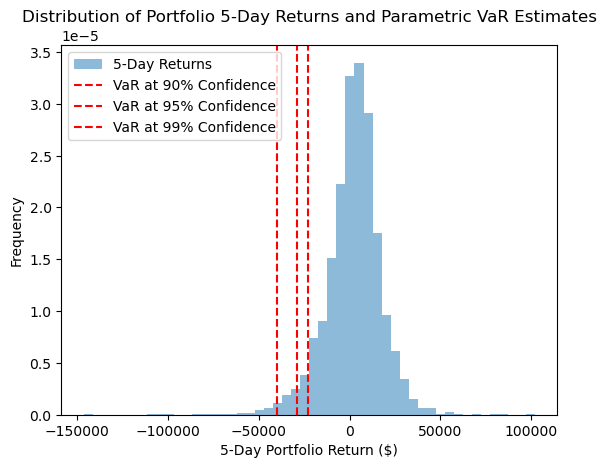

In [9]:
# Convert returns to dollar values for the histogram
historical_x_day_returns_dollar = historical_x_day_returns * portfolio_value

# Plot the histogram
plt.hist(historical_x_day_returns_dollar, bins=50, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add vertical lines representing VaR at each confidence level
for cl, VaR in zip(confidence_levels, VaRs):
    plt.axvline(x=VaR, linestyle='--', color='r', label='VaR at {}% Confidence'.format(int(cl * 100)))

plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates')
plt.legend()
plt.show()